In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import json
from pathlib import Path
from datetime import timedelta, datetime
from scipy.sparse import csr_matrix, vstack


import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
mp_drive_dir = Path("/media/hpi_share/")#Path("//FS23/projekte$/MP2021/MPWS2021/MPWS2021FN1")
mp_plot_dir = mp_drive_dir / "plots"
input_path = Path("../../../data")
input_data = list(input_path.rglob("*.json"))
files = [x for x in input_data if x.is_file()]
len(files) # total 580

586

In [4]:
num_edits = 0
change_tuples = []
#np.random.seed(42)
for file in tqdm(np.random.choice(files, 70, replace=False)):
    with open(file, 'r', encoding='utf-8') as f:
        for jsonObj in f:
            single_edit = json.loads(jsonObj)
            #entries.append(single_edit)
            key = single_edit['key']
            pid = single_edit['pageID']
            user = single_edit['username'] if 'username' in single_edit.keys() else None
            title = single_edit['pageTitle']#['key']
            changes = single_edit['changes']
            timestamp = single_edit['validFrom']
            edit_type = single_edit['type']
            for change in changes:
                name = change['property']['name']
                if 'currentValue' in change.keys() and 'previousValue' in change.keys():
                    current_value = change['currentValue'] if 'currentValue' in change.keys() else None
                    previous_value = change['previousValue'] if 'previousValue' in change.keys() else None
                    if current_value != '' and previous_value != '':
                        change_tuples.append((key, pid, title, user, name, previous_value, current_value, timestamp, edit_type))

  0%|          | 0/70 [00:00<?, ?it/s]

In [5]:
data = pd.DataFrame(change_tuples, columns=['key', 'pageID', 'title', 'user','name', 'previous_value', 'current_value', 'timestamp', 'edit_type'])
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.tz_localize(None)

In [6]:
bins = pd.date_range(data['timestamp'].min().date(), data['timestamp'].max().date()+timedelta(1))
total_days = len(bins)
bins = pd.cut(data['timestamp'], bins, labels=False)
data['bin_idx'] = bins

In [7]:
def create_time_series(a, duration):
    series = np.zeros(duration)
    uniques, counts = np.unique(a, return_counts=True)
    series[uniques] = counts
    return csr_matrix(series)

def create_bool_time_series(a, duration):
    series = np.zeros(duration, dtype=bool)
    uniques, counts = np.unique(a, return_counts=True)
    series[uniques] = 1
    return series

In [8]:
print(f"Num data points: {len(data)}")

Num data points: 8002985


In [9]:
num_required_changes = 10
groups = data.groupby(['key', 'name'])
min_support_groups = data[groups['bin_idx'].transform('count') > num_required_changes].groupby(['key', 'name'])

In [10]:
%%time
min_support_groups = min_support_groups['bin_idx'].apply(create_time_series, duration=total_days)

CPU times: user 38.6 s, sys: 177 ms, total: 38.8 s
Wall time: 38.9 s


In [11]:
print(f"Number of properties: {len(groups)}")
group_index = min_support_groups.index
#x = groups.loc["100593997-0"].values
x = vstack(min_support_groups.to_numpy())
print(f"Len min support groups : {x.shape[0]}")
#x = csr_matrix(x)

Number of properties: 2389174
Len min support groups : 115486


## Nearest Neighbors
Probably more suited than clustering methods

In [26]:
from sklearn.metrics import pairwise_distances

In [73]:
def percentage_eucledian(arr1, arr2):
    arr1 = arr1.toarray()
    arr2 = arr2.toarray()
    return  np.sum(np.absolute(arr1 - arr2)) / max(arr1.sum(), arr2.sum())

In [67]:
%%timeit
percentage_eucledian(x[312], x[311])

186 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [75]:
%%timeit
pairwise_distances(x, metric='manhattan')

7.54 ms ± 92.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
%%timeit
pairwise_distances(x, metric=percentage_eucledian)

24.1 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit
percentage_eucledian(x[312], x[311])

727 µs ± 28.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
x = x[:500]

In [44]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
#max_dist = 2
max_dist = 0.2
neigh = NearestNeighbors(radius=max_dist, p=1)
#neigh = NearestNeighbors(radius=max_dist, metric=percentage_eucledian)
neigh.fit(x)

NearestNeighbors(p=1, radius=0.2)

In [45]:
%%time
dist, ind = neigh.radius_neighbors()

CPU times: user 78.7 ms, sys: 0 ns, total: 78.7 ms
Wall time: 15.6 ms


In [39]:
a = group_index.values
same_infobox = []
for i, indices in enumerate(ind):
    infobox = group_index[i][0]
    if len(indices) > 0:
        matching_pages = np.array([key[0] for key in group_index[indices]])
        same_infobox.append(infobox == matching_pages)
n_total = len(ind)
n_matched = len(same_infobox)

In [40]:
print(f"number of pages considered: {data['pageID'].nunique()}")

number of pages considered: 303523


/home/niklaskoehnecke/project/wikipedia_cleanup/.venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/niklaskoehnecke/project/wikipedia_cleanup/.venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.1, 0, 'Color represents the % of matches that are not from the same infobox')

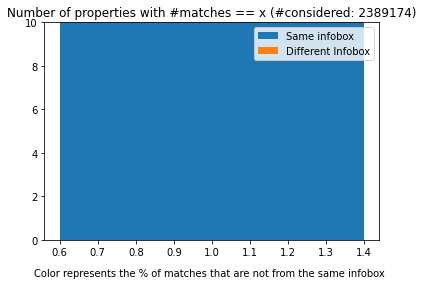

In [41]:
num_matches = []
percent_same_matched = []
max_num_matches = 100
for i in range(1, max_num_matches):
    num_matches.append(np.sum(np.fromiter( (len(a) for a in same_infobox), dtype=int) == i))
    percent_same_matched.append(np.mean([np.sum(entry) / i for entry in same_infobox if len(entry) == i]))
percent_same_infobox = np.multiply(num_matches, percent_same_matched)
plt.bar(range(1, max_num_matches), percent_same_infobox, label='Same infobox')
plt.bar(range(1, max_num_matches), num_matches-percent_same_infobox, bottom = percent_same_infobox, label='Different Infobox')
plt.legend(loc='upper right')
plt.title(f"Number of properties with #matches == x (#considered: {len(groups)})")
plt.figtext(0.1, 0, "Color represents the % of matches that are not from the same infobox")

In [ ]:
#0.963084495488105
# 95 93 87 87 95
# 93 91 84 93 87
# 94 91 80 90 88
percent_same_matched

Look at some of the examples
 - Many examples have just creation / deletion
 - When filtering these out, some examples are:
     - batting averages (247568784-0), box2..., Statistics in general
     - Temperature reading for cities (infoboxes that are basically plots) - https://de.wikipedia.org/wiki/Ottawa
     - Uniforms for soccer games and stuff https://en.wikipedia.org/wiki/FC_Bayern_Munich_(women)
     - Perfect synchronous data https://en.wikipedia.org/wiki/Delta_County_Airport
     - Career listings and other list elements - https://en.wikipedia.org/wiki/Akaki_Khubutia
     - Stuff that is updated real time, once (Elections https://en.wikipedia.org/wiki/2019_European_Parliament_election_in_the_United_Kingdom)
     - railway stations , passenger numbers (https://en.wikipedia.org/wiki/Windsor_station_(Vermont))
     - Vandalism

In [ ]:
a = group_index[ind[np.array([len(g) for g in ind]) > 2][70]]
print(a)
a = a[6]
data[(data['name'] == a[1]) & (data['key'] == a[0])]

In [ ]:
data[data['key'] == '131458332-1']

In [ ]:
data[data['key'] == '131458332-2']

In [ ]:
data[(data['name'] == 'ability') & (data['key'] == '131458332-2')]

In [ ]:
ind[np.array([len(g) for g in ind]) > 20]

In [ ]:
group_index[ind[np.array([len(g) for g in ind]) > 20][123]]
data[(data['key'] == '110474295-0') & (data['name'] == 'area_rank')]

## KShape, apparently good fast clustering
Seems to be ill-suited for the job

In [ ]:
plt.figure(figsize=(100,2))
for k, row in groups.loc["100593997-0"].items():
    plt.plot(row)

In [ ]:
from tslearn.clustering import KShape
n_clusters = 4
classifier = KShape(n_clusters)
classifier.fit(x)
predictions = classifier.predict(x)

In [ ]:
for i in range(n_clusters):
    selected_data = x[predictions==i]
    plt.figure(figsize=(100,2))
    for j in range(len(selected_data)):
        plt.plot(selected_data[j])
    plt.show()

## DBScan

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
from dtaidistance import dtw

In [ ]:
print(dtw.distance.__doc__)

In [ ]:
def change_distance(a, b):
    return dtw.distance(a, b, window=14, use_pruning=True, use_c=True)

In [ ]:
x.shape

In [ ]:
%%time
clustering = DBSCAN(eps=1, min_samples=2, n_jobs=6, metric=change_distance).fit(x)

In [ ]:
clusters = np.unique(clustering.labels_)
n_clusters = len(clusters)
if -1 in clusters:
    n_clusters -=1

In [ ]:
for i in range(n_clusters):
    selected_data = x[clustering.labels_==i]
    plt.figure(figsize=(100,2))
    for j in range(len(selected_data)):
        plt.plot(selected_data[j])
    plt.show()